# Práctica  Escenarios de Estrés y Cambios de Régimen

## Objetivo (resumen)
Construir un motor interpretable de detección de regímenes (calma/crisis) y simulación multiactivo con cópulas,
capaz de generar escenarios de estrés y cuantificar pérdidas extremas (VaR 99% y ES/CVaR 99%).

## Datos (diario, 2006-01-01 → hoy)
Universo de cartera equiponderada (sin rebalanceo):
- Renta variable/acciones: AAPL, AMZN, BAC, BRK-B, CVX, ENPH, GME, GOOGL, JNJ, JPM, MSFT, NVDA, PG, XOM
- Oro: GLD
- High Yield: HYG
- Bonos gobierno USA 10Y y 2Y (proxies líquidos): IEF (7–10Y Treasury) y SHY (1–3Y Treasury)
  *Además descargamos las yields DGS10 y DGS2 (FRED) como indicadores de tipos*
- Mercado (proxy para gráficos/regímenes): SPY (S&P 500)

Fuentes:
- Precios ajustados (acciones/ETFs): Yahoo Finance (via `yfinance`)
- Series macro/crediticias (yields y spread HY): FRED (via `pandas_datareader`)


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime, timezone

try:
    from hmmlearn.hmm import GaussianHMM
except Exception:
    %pip -q install hmmlearn
    from hmmlearn.hmm import GaussianHMM

from sklearn.preprocessing import StandardScaler

In [3]:
# =========================
# Parámetros generales
# =========================
START = "2006-01-01"
END = datetime.now().date().isoformat()   # "hasta la fecha"
SEED = 42
np.random.seed(SEED)

# =========================
# Universo (precios)
# =========================
# Acciones + ETFs del enunciado
tickers_prices = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL",
    "JNJ","JPM","MSFT","NVDA","PG","XOM",
    "HYG",   # High Yield ETF (precio/retornos)
    "SPY",   # mercado (proxy S&P500)
    "IEF","SHY"  # proxis líquidos para UST 10Y y 2Y (aprox.)
]

# Series FRED (indicadores interpretables)
fred_series = {
    "DGS10": "UST_10Y_YIELD",          # 10Y yield
    "DGS2":  "UST_2Y_YIELD",           # 2Y yield
    "BAMLH0A0HYM2": "HY_OAS_SPREAD"    # spread HY (enunciado)
}

# =========================
# Descarga precios (Yahoo)
# =========================
# auto_adjust=True -> precios ajustados (splits/dividendos)
px = yf.download(
    tickers_prices,
    start=START,
    end=END,
    auto_adjust=True,
    progress=False
)["Close"]

# yfinance devuelve Series si solo 1 ticker; normalizamos
if isinstance(px, pd.Series):
    px = px.to_frame()

# =========================
# Descarga FRED (yields/spread)
# =========================
fred = pdr.DataReader(list(fred_series.keys()), "fred", START, END)
fred = fred.rename(columns=fred_series)

# =========================
# Alinear frecuencia y limpiar
# =========================
# Nos vamos a calendario de negocio (B) y rellenamos huecos:
# - Precios: forward-fill (mercados cerrados/holiday)
# - FRED: forward-fill (publicación diaria con huecos)
idx = pd.date_range(START, END, freq="B")

px = px.reindex(idx).ffill()
fred = fred.reindex(idx).ffill()

# Eliminamos columnas que hayan quedado completamente vacías (por si algún ticker falla)
px = px.dropna(axis=1, how="all")
fred = fred.dropna(axis=1, how="all")

# =========================
# Retornos log (para modelos)
# =========================
ret = np.log(px).diff().dropna()

# Dataset final (útil para exploración)
data = pd.concat([px.add_prefix("PX_"), fred.add_prefix("FRED_")], axis=1)

print("Rango (Business Days):", idx.min().date(), "->", idx.max().date())
print("Precios descargados:", px.shape[1], "activos |", list(px.columns))
print("FRED descargado:", fred.shape[1], "series |", list(fred.columns))
print("\nRetornos (log) shape:", ret.shape)
display(data)

Rango (Business Days): 2006-01-02 -> 2026-02-06
Precios descargados: 19 activos | ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GLD', 'GME', 'GOOGL', 'HYG', 'IEF', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'SHY', 'SPY', 'XOM']
FRED descargado: 3 series | ['UST_10Y_YIELD', 'UST_2Y_YIELD', 'HY_OAS_SPREAD']

Retornos (log) shape: (3615, 19)


,PX_AAPL,PX_AMZN,PX_BAC,PX_BRK-B,PX_CVX,PX_ENPH,PX_GLD,PX_GME,PX_GOOGL,PX_HYG,...,PX_JPM,PX_MSFT,PX_NVDA,PX_PG,PX_SHY,PX_SPY,PX_XOM,FRED_UST_10Y_YIELD,FRED_UST_2Y_YIELD,FRED_HY_OAS_SPREAD
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,2.241832,2.379000,30.660288,59.299999,27.413305,NaN,53.119999,2.719291,10.809964,NaN,...,23.754637,18.715061,0.292012,33.320015,55.632408,87.463257,29.622831,4.37,4.34,3.73
2006-01-04,2.248429,2.362500,30.334669,59.340000,27.334433,NaN,53.299999,2.815236,11.058587,NaN,...,23.617535,18.805710,0.300187,33.382366,55.687801,87.877449,29.673502,4.36,4.31,3.69
2006-01-05,2.230735,2.382500,30.373722,59.200001,27.000362,NaN,52.340000,3.140103,11.207610,NaN,...,23.689066,18.819654,0.306986,33.274662,55.639290,87.932693,29.526571,4.36,4.32,3.64
2006-01-06,2.288316,2.393500,30.328156,59.400002,27.492197,NaN,53.720001,3.241940,11.565765,NaN,...,23.855967,18.763868,0.312029,33.240646,55.653160,88.664406,30.109196,4.38,4.36,3.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-02,270.010010,242.960007,54.029999,487.290009,174.029999,36.470001,427.130005,25.850000,343.690002,80.769997,...,308.140015,423.369995,185.610001,153.190002,82.699997,695.409973,138.399994,4.29,3.57,2.81
2026-02-03,269.480011,238.619995,54.450001,493.739990,178.039993,37.279999,454.290009,24.520000,339.709991,80.720001,...,314.850006,411.209991,180.339996,155.320007,82.690002,689.530029,143.729996,4.28,3.57,2.85
2026-02-04,276.489990,232.990005,55.380001,503.829987,181.229996,51.669998,453.970001,24.980000,333.040009,80.620003,...,317.269989,414.190002,174.190002,156.869995,82.730003,686.190002,147.589996,4.29,3.57,2.86
2026-02-05,275.910004,222.690002,54.939999,503.890015,179.229996,47.270000,441.880005,24.690001,331.250000,80.529999,...,310.160004,393.670013,171.880005,158.610001,82.860001,677.619995,146.080002,4.21,3.47,2.97


En esta práctica se utilizan ETFs líquidos (por ejemplo, SPY, IEF, SHY, GLD y HYG) como proxies de los activos financieros subyacentes
(renta variable, bonos gubernamentales, oro y crédito high yield).
La elección responde a criterios de **liquidez y coherencia económica**.

Los ETFs proporcionan **precios diarios ajustados**, negociados en mercado continuo, lo que permite construir retornos homogéneos
y comparables entre activos desde 2006 sin problemas de iliquidez o falta de observaciones.
Esto es especialmente relevante en el caso de la renta fija, donde los bonos individuales no cotizan diariamente y presentan
problemas de precios “stale”.

Además, los ETFs reflejan de forma agregada el comportamiento de su clase de activo
(p. ej. SPY para el mercado accionario estadounidense o IEF/SHY para la curva de tipos),
lo que los hace adecuados para el análisis de **regímenes de mercado y escenarios de estrés**.
De este modo, se prioriza la estabilidad estadística del dataset y la interpretabilidad económica de los resultados.


# Fase 1 — Detección de regímenes con Gaussian HMM (2 estados)

Modelizamos el “pulso” del mercado asumiendo que existen **dos regímenes latentes**: *calma* y *crisis*.
Para estimarlos, ajustamos un **Gaussian Hidden Markov Model (HMM)** con **2 estados** sobre una matriz de retornos diarios
(multiactivo), de forma que el modelo aprenda:

- La **distribución** de retornos típica en cada estado (media y covarianza).
- La **dinámica temporal** (probabilidad de permanecer en el estado o cambiar al otro).

Una vez entrenado, inferimos para cada día el estado más probable y lo **representamos sobre el S&P 500 (SPY)**,
coloreando el fondo: **Blanco = Calma**, **Azul = Crisis**.


Inicio efectivo (features HMM): 2007-01-01 | Fin: 2026-02-06
Features: ['SPY_ret', 'SPY_RV20', 'SPY_RV63', 'dHY_OAS_20d', 'dSLOPE_20d', 'IEF_ret', 'GLD_ret']

Resumen por estado:
            mean_ret  vol_RV20  mean_dHY
state_raw                              
0          0.000611  0.109272 -0.089658
1         -0.000009  0.248599  0.148708

Score crisis:
 state_raw
0    0.108660
1    0.397315
dtype: float64

Crisis_state: 1

Transmat:
 [[0.99114476 0.00885524]
 [0.01643666 0.98356334]]

N episodios: 16
Primeros: [(np.datetime64('2007-08-07T00:00:00.000000000'), np.datetime64('2007-09-26T00:00:00.000000000')), (np.datetime64('2007-10-31T00:00:00.000000000'), np.datetime64('2008-06-20T00:00:00.000000000')), (np.datetime64('2008-07-08T00:00:00.000000000'), np.datetime64('2009-10-16T00:00:00.000000000')), (np.datetime64('2010-05-18T00:00:00.000000000'), np.datetime64('2010-09-16T00:00:00.000000000')), (np.datetime64('2011-08-12T00:00:00.000000000'), np.datetime64('2012-02-15T00:00:00.0000000

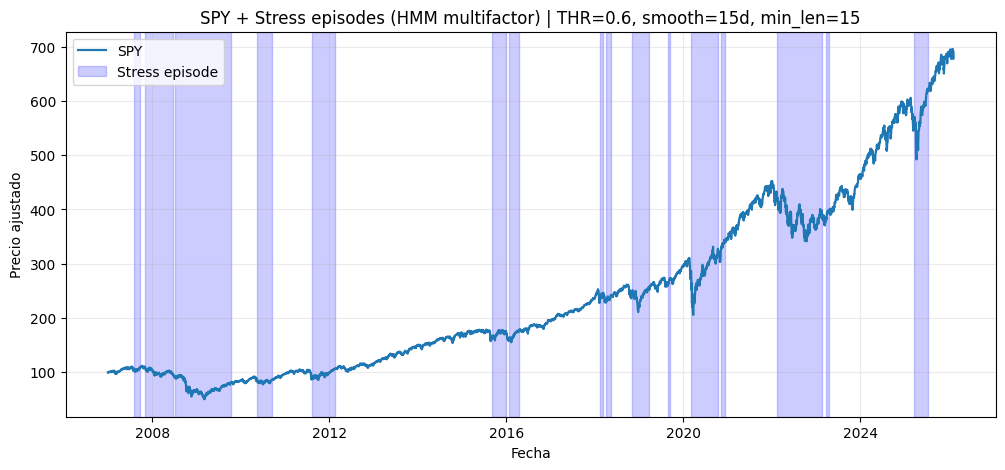

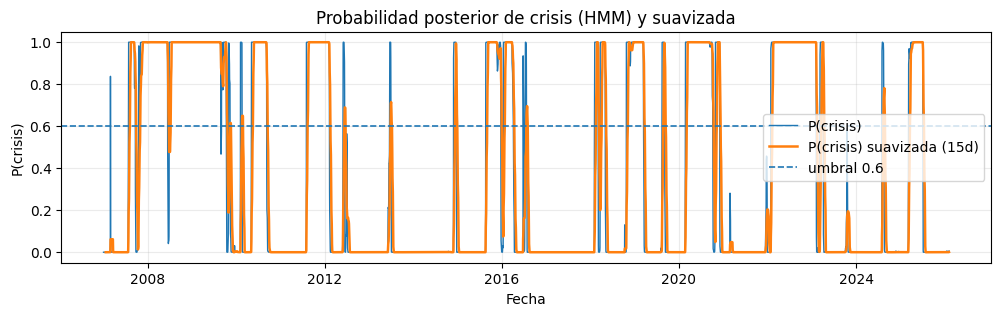

In [4]:
# =========================
# Parámetros (ajustables)
# =========================
START = "2007-01-01"
RV1 = 20          # RV corto (estrés agudo)
RV2 = 63          # RV medio (estrés persistente)
D_MACRO = 20      # cambios "mensuales" para FRED (evita ruido semanal)
N_STATES = 2
SEED = 42

SMOOTH = 15       # suavizado de prob. crisis
THR = 0.60        # umbral de crisis
MIN_LEN = 15      # mínimo días para episodio
GAP_TOL = 5       # fusionar episodios si gap <= GAP_TOL

# =========================
# 0) FIX: retornos SIN dropna global (para no recortar por ENPH)
# =========================
ret = np.log(px).diff()

# =========================
# 1) Features sistémicas (multifactor, interpretables)
# =========================
idx = px.index
feat = pd.DataFrame(index=idx)

# Mercado
spy = px["SPY"].ffill()
feat["SPY_ret"] = ret["SPY"]
feat[f"SPY_RV{RV1}"] = ret["SPY"].rolling(RV1).std() * np.sqrt(252)
feat[f"SPY_RV{RV2}"] = ret["SPY"].rolling(RV2).std() * np.sqrt(252)

# Crédito (cambios, no niveles)
hy = data["FRED_HY_OAS_SPREAD"].reindex(idx).ffill()
feat[f"dHY_OAS_{D_MACRO}d"] = hy.diff(D_MACRO)

# Tipos (cambios en pendiente, no nivel)
y10 = data["FRED_UST_10Y_YIELD"].reindex(idx).ffill()
y2  = data["FRED_UST_2Y_YIELD"].reindex(idx).ffill()
slope = (y10 - y2)
feat[f"dSLOPE_{D_MACRO}d"] = slope.diff(D_MACRO)

# “Flight to quality” (opcional pero suele ayudar)
if "IEF" in ret.columns:
    feat["IEF_ret"] = ret["IEF"]
if "GLD" in ret.columns:
    feat["GLD_ret"] = ret["GLD"]

# Recortamos a partir de START y quitamos NaNs solo aquí
feat = feat.loc[feat.index >= START].dropna()

print("Inicio efectivo (features HMM):", feat.index.min().date(), "| Fin:", feat.index.max().date())
print("Features:", list(feat.columns))

# Winsorización ligera para que un par de días extremos no dominen (opcional pero útil)
feat_clip = feat.copy()
for c in feat_clip.columns:
    lo, hi = feat_clip[c].quantile([0.01, 0.99])
    feat_clip[c] = feat_clip[c].clip(lo, hi)

# =========================
# 2) HMM (2 estados)
# =========================
scaler = StandardScaler()
Z = scaler.fit_transform(feat_clip.values)

hmm = GaussianHMM(
    n_components=N_STATES,
    covariance_type="full",
    n_iter=3000,
    random_state=SEED
)
hmm.fit(Z)

states = pd.Series(hmm.predict(Z), index=feat_clip.index, name="state_raw")
post = pd.DataFrame(hmm.predict_proba(Z), index=feat_clip.index, columns=[0, 1])

# Etiquetar crisis con criterio económico (vol alta + spread widening + peor retorno)
stats = pd.DataFrame({
    "mean_ret": feat_clip["SPY_ret"].groupby(states).mean(),
    "vol_RV20": feat_clip[f"SPY_RV{RV1}"].groupby(states).mean(),
    "mean_dHY": feat_clip[f"dHY_OAS_{D_MACRO}d"].groupby(states).mean()
})

# Score: estrés = vol alta + subida de spread + retorno medio más bajo
score = stats["vol_RV20"] + stats["mean_dHY"].clip(lower=0) - stats["mean_ret"]
crisis_state = int(score.idxmax())

p_crisis = post[crisis_state]
p_smooth = p_crisis.rolling(SMOOTH).mean()

stress01 = (p_smooth > THR).astype(int)

print("\nResumen por estado:\n", stats)
print("\nScore crisis:\n", score)
print("\nCrisis_state:", crisis_state)
print("\nTransmat:\n", hmm.transmat_)

# =========================
# 3) Convertir stress diario -> EPISODIOS (min duración + merge gaps)
# =========================
def build_episodes(stress: pd.Series, min_len=15, gap_tol=5):
    s = stress.astype(int).values
    t = stress.index.to_numpy()

    changes = np.diff(np.r_[0, s, 0])
    starts = np.where(changes == 1)[0]
    ends   = np.where(changes == -1)[0]  # exclusivo

    segs = []
    for a, b in zip(starts, ends):
        if (b - a) >= min_len:
            segs.append([a, b])

    if not segs:
        return []

    merged = [segs[0]]
    for a, b in segs[1:]:
        pa, pb = merged[-1]
        if (a - pb) <= gap_tol:
            merged[-1][1] = b
        else:
            merged.append([a, b])

    return [(t[a], t[b-1]) for a, b in merged]

episodes = build_episodes(stress01, min_len=MIN_LEN, gap_tol=GAP_TOL)
print("\nN episodios:", len(episodes))
print("Primeros:", episodes[:6])

# =========================
# 4) Plot: SPY + episodios
# =========================
spy_plot = px["SPY"].reindex(feat_clip.index).ffill()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(spy_plot.index, spy_plot.values, linewidth=1.6, label="SPY")

for (a, b) in episodes:
    ax.axvspan(a, b, alpha=0.20, color="blue", label="Stress episode")

# leyenda sin duplicados
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
ax.legend(uniq.values(), uniq.keys(), loc="upper left")

ax.set_title(f"SPY + Stress episodes (HMM multifactor) | THR={THR}, smooth={SMOOTH}d, min_len={MIN_LEN}")
ax.set_xlabel("Fecha")
ax.set_ylabel("Precio ajustado")
ax.grid(True, alpha=0.25)
plt.show()

# Plot de probabilidad (diagnóstico)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(p_crisis.index, p_crisis, linewidth=1.0, label="P(crisis)")
ax.plot(p_smooth.index, p_smooth, linewidth=1.8, label=f"P(crisis) suavizada ({SMOOTH}d)")
ax.axhline(THR, linestyle="--", linewidth=1.2, label=f"umbral {THR}")
ax.set_title("Probabilidad posterior de crisis (HMM) y suavizada")
ax.set_xlabel("Fecha")
ax.set_ylabel("P(crisis)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# Fase 2 — Anatomía del Riesgo 

En esta fase cuantificamos cómo cambian las distribuciones **individuales** de los retornos cuando el mercado pasa de *calma* a *crisis*.

Para cada activo calculamos, **condicional a cada estado** (Estado 0 = Calma, Estado 1 = Crisis):
- **Media** (retorno esperado diario)
- **Volatilidad** (desviación típica diaria)
- **Skewness** (asimetría)
- **Kurtosis (exceso)** (colas: >0 indica colas más pesadas que normal)

Además, respondemos:
1) ¿Cuánto aumenta la volatilidad de **HYG** al pasar de Estado 0 a Estado 1?  
2) ¿Sigue siendo **GLD** un activo refugio? (lo evaluamos por su media/vol en crisis y, como extra, su correlación con SPY en crisis).


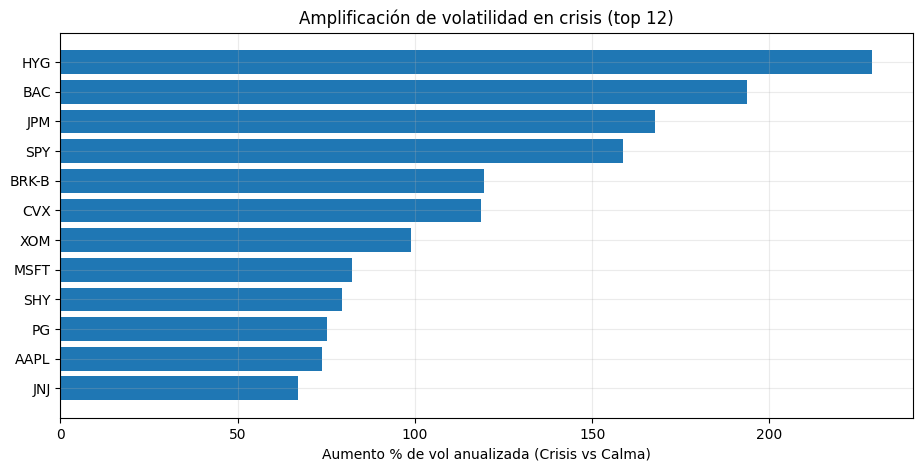

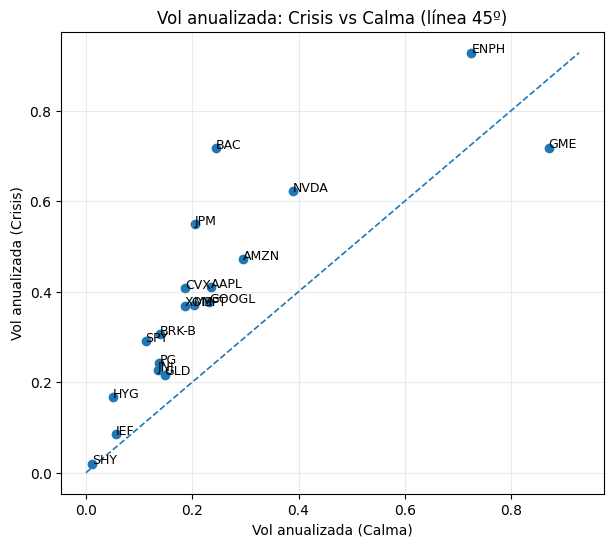

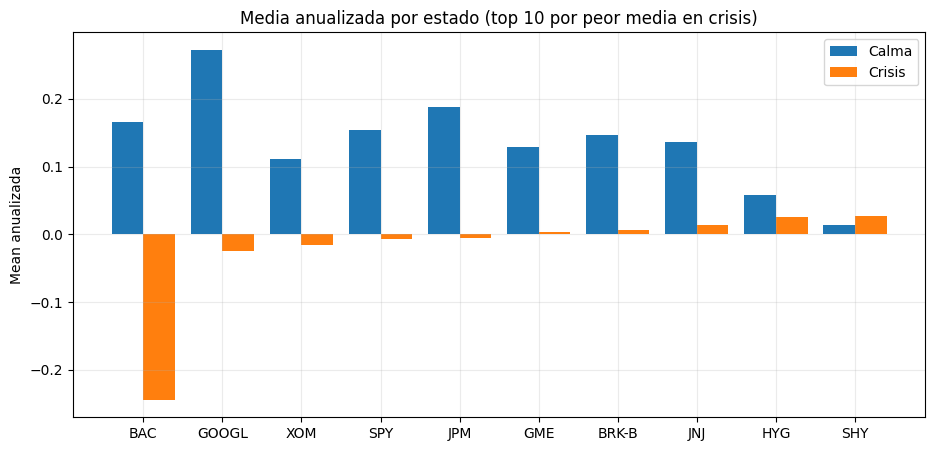

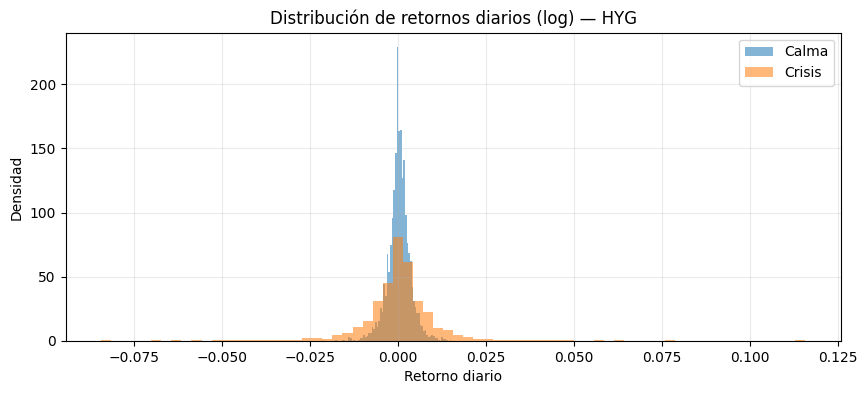

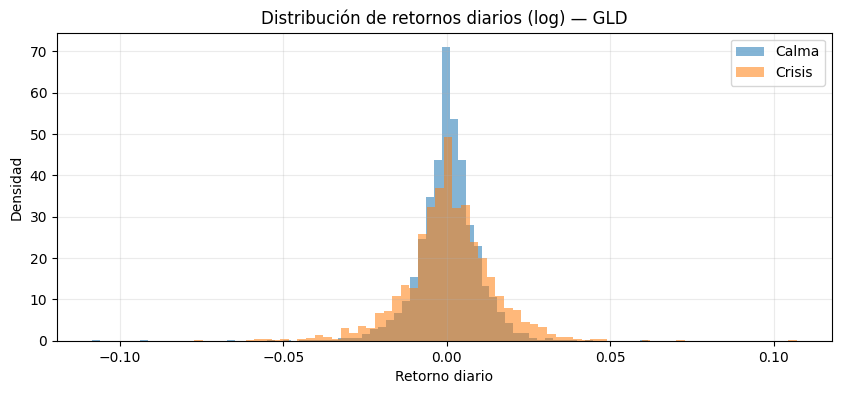

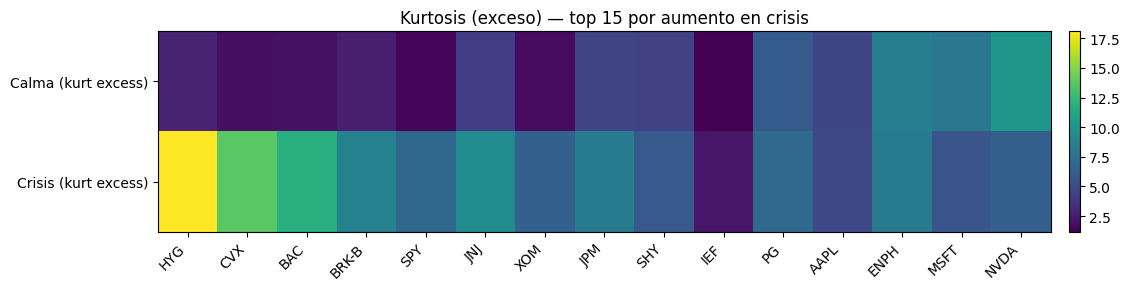


================= RESPUESTAS FASE 2 =================

(HYG) Vol anualizada Calma:  0.0508
(HYG) Vol anualizada Crisis: 0.1673
(HYG) Aumento (%):           229.06%  | Ratio: 3.291

(GLD) Mean anualizada Calma:  0.0783
(GLD) Mean anualizada Crisis: 0.1399  | Δ: 0.0616
(GLD) Vol anualizada Calma:   0.1481
(GLD) Vol anualizada Crisis:  0.2168  | Ratio: 1.463
(GLD vs SPY) Corr Calma: 0.098 | Corr Crisis: 0.035


In [7]:
# -----------------------------
# Checks
# -----------------------------
if "states" not in globals() or "crisis_state" not in globals():
    raise ValueError("No encuentro `states` y/o `crisis_state`. Ejecuta primero la Fase 1 (HMM).")

# -----------------------------
# 1) Estado 0/1: 0=Calma, 1=Crisis
# -----------------------------
S01 = (states == int(crisis_state)).astype(int)
S01.name = "state01"

# -----------------------------
# 2) Retornos del universo (log) sin dropna global
# -----------------------------
universe = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL","JNJ",
    "JPM","MSFT","NVDA","PG","XOM",
    "IEF","SHY","HYG","SPY"
]
universe = [t for t in universe if t in px.columns]

R = np.log(px[universe]).diff()  # SIN dropna global
common_idx = R.index.intersection(S01.index)
R = R.loc[common_idx]
S01 = S01.loc[common_idx]

# -----------------------------
# 3) Momentos condicionales por estado
# -----------------------------
def moments(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "N": df.count(),
        "mean_d": df.mean(),
        "vol_d": df.std(),
        "skew": df.skew(),
        "kurt_excess": df.kurt()   # exceso de kurtosis (Fisher)
    })
    out["mean_ann"] = out["mean_d"] * 252
    out["vol_ann"]  = out["vol_d"] * np.sqrt(252)
    return out

mom_calm   = moments(R[S01==0]).add_prefix("calm_")
mom_crisis = moments(R[S01==1]).add_prefix("crisis_")

tab = pd.concat([mom_calm, mom_crisis], axis=1)

tab["vol_ratio"] = tab["crisis_vol_ann"] / tab["calm_vol_ann"]
tab["vol_increase_%"] = (tab["vol_ratio"] - 1.0) * 100
tab["mean_diff_ann"] = tab["crisis_mean_ann"] - tab["calm_mean_ann"]
tab["kurt_diff"] = tab["crisis_kurt_excess"] - tab["calm_kurt_excess"]
tab["skew_diff"] = tab["crisis_skew"] - tab["calm_skew"]

# Si algún activo tiene pocos datos en un estado, mejor filtrarlo un poco
MIN_N = 400
mask = (tab["calm_N"] >= MIN_N) & (tab["crisis_N"] >= MIN_N)
tab_f = tab[mask].copy()

# -----------------------------
# 4) VISUALES
# -----------------------------
# (A) Top "amplificación" de volatilidad
topN = 12
rank = tab_f.sort_values("vol_increase_%", ascending=False).head(topN)

fig, ax = plt.subplots(figsize=(11, 5))
ax.barh(rank.index[::-1], rank["vol_increase_%"][::-1])
ax.set_title(f"Amplificación de volatilidad en crisis (top {topN})")
ax.set_xlabel("Aumento % de vol anualizada (Crisis vs Calma)")
ax.grid(True, alpha=0.25)
plt.show()

# (B) Scatter: vol crisis vs vol calma (línea 45º)
fig, ax = plt.subplots(figsize=(7, 6))
x = tab_f["calm_vol_ann"].values
y = tab_f["crisis_vol_ann"].values
ax.scatter(x, y)

mx = np.nanmax([x.max(), y.max()])
ax.plot([0, mx], [0, mx], linestyle="--", linewidth=1.2)  # línea 45º

# Etiquetar solo algunos (los más relevantes) para no saturar
labels = tab_f.index.tolist()
for t in labels:
    ax.annotate(t, (tab_f.loc[t, "calm_vol_ann"], tab_f.loc[t, "crisis_vol_ann"]), fontsize=9)

ax.set_title("Vol anualizada: Crisis vs Calma (línea 45º)")
ax.set_xlabel("Vol anualizada (Calma)")
ax.set_ylabel("Vol anualizada (Crisis)")
ax.grid(True, alpha=0.25)
plt.show()

# (C) Mean anualizada: comparación Calma vs Crisis (top 10 por peor media en crisis)
topM = 10
rank_mean = tab_f.sort_values("crisis_mean_ann").head(topM)  # <- aquí definimos rank_mean

fig, ax = plt.subplots(figsize=(11, 5))
idx = np.arange(len(rank_mean))
ax.bar(idx - 0.2, rank_mean["calm_mean_ann"].values, width=0.4, label="Calma")
ax.bar(idx + 0.2, rank_mean["crisis_mean_ann"].values, width=0.4, label="Crisis")
ax.set_xticks(idx)
ax.set_xticklabels(rank_mean.index, rotation=0)
ax.set_title(f"Media anualizada por estado (top {topM} por peor media en crisis)")
ax.set_ylabel("Mean anualizada")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()


# (D) Distribuciones (hist) para HYG y GLD por estado
def plot_hist_asset(ticker, bins=70):
    if ticker not in R.columns:
        print(f"[WARN] {ticker} no está en retornos.")
        return
    r0 = R.loc[S01==0, ticker].dropna()
    r1 = R.loc[S01==1, ticker].dropna()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(r0.values, bins=bins, density=True, alpha=0.55, label="Calma")
    ax.hist(r1.values, bins=bins, density=True, alpha=0.55, label="Crisis")
    ax.set_title(f"Distribución de retornos diarios (log) — {ticker}")
    ax.set_xlabel("Retorno diario")
    ax.set_ylabel("Densidad")
    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.show()

plot_hist_asset("HYG")
plot_hist_asset("GLD")

# (E) “Mapa rápido” de colas/asimetría (top por kurtosis diff)
topK = 15
rank_k = tab_f.sort_values("kurt_diff", ascending=False).head(topK)
vals = np.vstack([rank_k["calm_kurt_excess"].values, rank_k["crisis_kurt_excess"].values])

fig, ax = plt.subplots(figsize=(12, 2.6))
im = ax.imshow(vals, aspect="auto")
ax.set_yticks([0,1])
ax.set_yticklabels(["Calma (kurt excess)", "Crisis (kurt excess)"])
ax.set_xticks(np.arange(topK))
ax.set_xticklabels(rank_k.index, rotation=45, ha="right")
ax.set_title(f"Kurtosis (exceso) — top {topK} por aumento en crisis")
plt.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.show()

# -----------------------------
# 5) Respuestas directas a las preguntas (HYG y GLD)
# -----------------------------
print("\n================= RESPUESTAS FASE 2 =================")

if "HYG" in tab.index:
    hyg = tab.loc["HYG"]
    print(f"\n(HYG) Vol anualizada Calma:  {hyg['calm_vol_ann']:.4f}")
    print(f"(HYG) Vol anualizada Crisis: {hyg['crisis_vol_ann']:.4f}")
    print(f"(HYG) Aumento (%):           {hyg['vol_increase_%']:.2f}%  | Ratio: {hyg['vol_ratio']:.3f}")
else:
    print("\n(HYG) No disponible en el dataset.")

if "GLD" in tab.index:
    gld = tab.loc["GLD"]
    print(f"\n(GLD) Mean anualizada Calma:  {gld['calm_mean_ann']:.4f}")
    print(f"(GLD) Mean anualizada Crisis: {gld['crisis_mean_ann']:.4f}  | Δ: {gld['mean_diff_ann']:.4f}")
    print(f"(GLD) Vol anualizada Calma:   {gld['calm_vol_ann']:.4f}")
    print(f"(GLD) Vol anualizada Crisis:  {gld['crisis_vol_ann']:.4f}  | Ratio: {gld['vol_ratio']:.3f}")

    # Extra: correlación GLD vs SPY condicional
    if "SPY" in R.columns:
        corr_calm = R.loc[S01==0, "GLD"].corr(R.loc[S01==0, "SPY"])
        corr_cris = R.loc[S01==1, "GLD"].corr(R.loc[S01==1, "SPY"])
        print(f"(GLD vs SPY) Corr Calma: {corr_calm:.3f} | Corr Crisis: {corr_cris:.3f}")
else:
    print("\n(GLD) No disponible en el dataset.")


## Fase 3 — Cuando la diversificación falla (cópulas)

### 1) Correlación Pearson por régimen
- Se calcula la matriz de correlación de retornos diarios **condicional a cada estado** (HMM).
- Evidencia típica: en *Crisis* aumenta la **correlación media off-diagonal** y la distribución de correlaciones se desplaza hacia valores altos.
- En el subuniverso de **risk assets** (equity + HY) el efecto suele ser más marcado que cuando mezclamos defensivos (bonos/oro).

### 2) t-cópula multivariante (dependencia en colas)
- Se ajusta una **t-cópula** en cada régimen usando pseudo-observaciones (ranks → U(0,1)).
- La t-cópula introduce dependencia en colas mediante los **grados de libertad**:
  - **Alto** ⇒ comportamiento cercano a Gaussiana (colas “finas”) → típico de *Calma*.
  - **Bajo** ⇒ colas gruesas y más probabilidad de extremos conjuntos → típico de *Crisis*.

### 3) Extra: Clayton (bivariada) para cola izquierda
- Se usa **Clayton** como contraste específico de *riesgo*, ya que modela **dependencia de cola inferior**.
- A partir de Kendall  se obtiene theta y la métrica lambda (probabilidad de caídas conjuntas).
- En crisis se observan **pares con lambda significativamente mayor**, apoyando que la diversificación falla precisamente en la cola.

Activos totales: 19 | Risk assets: 15 | Defensivos: 3
Obs. totales alineadas: 4985 | % Crisis: 34.92477432296891 %

--- Pearson (activos con N>=MIN_N en ambos regímenes) ---
K = 19 | N_calm(min col count) = 2669 | N_crisis(min col count) = 946
Corr media off-diag (Calma):   0.1761712021563722
Corr media off-diag (Crisis):  0.31194908657992027


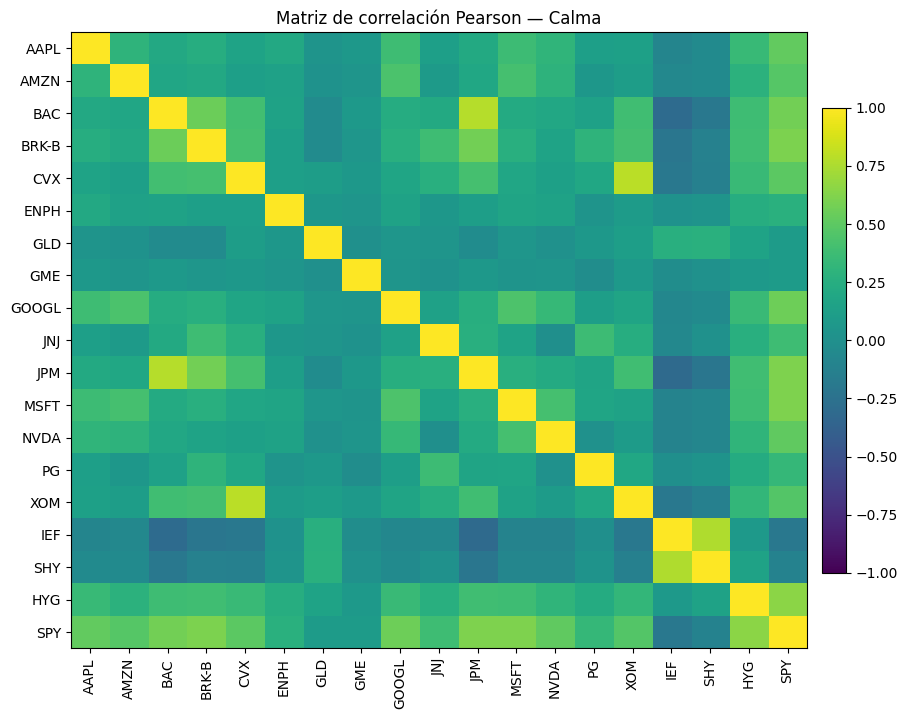

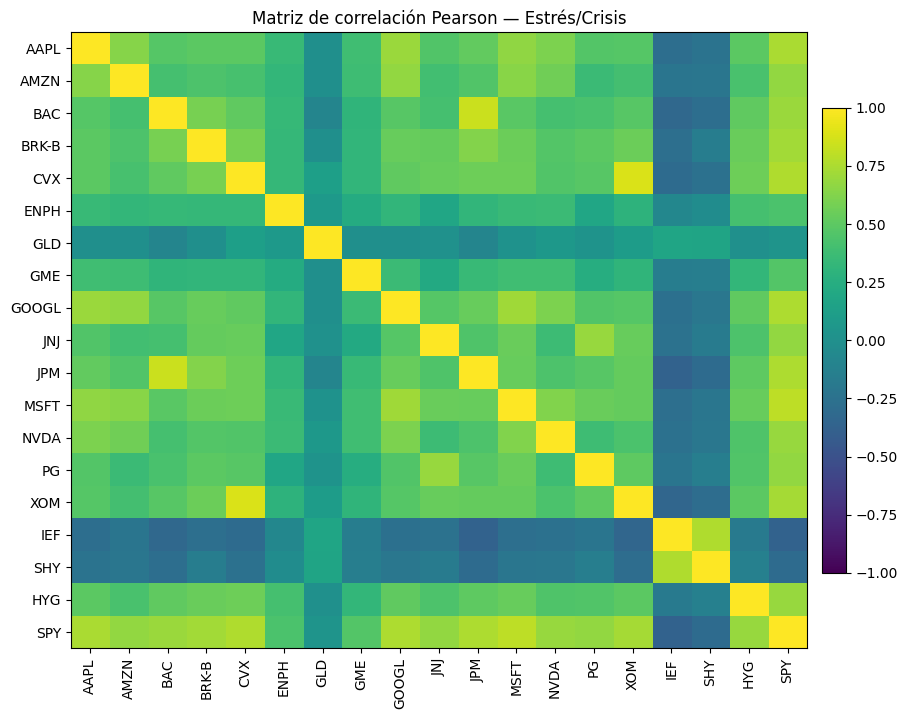

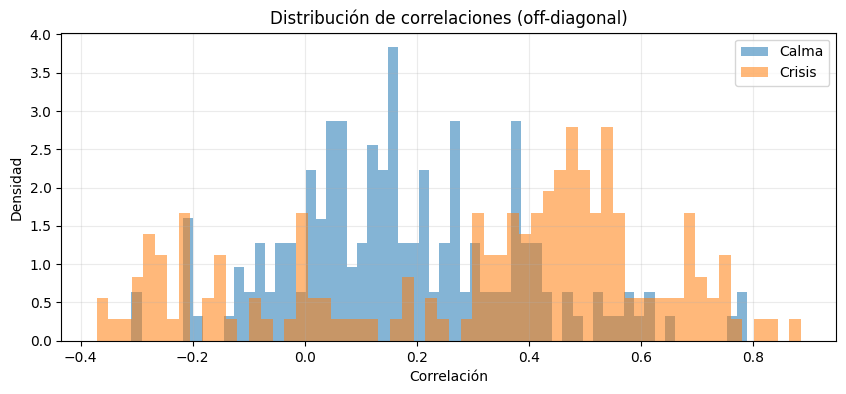


--- Solo Risk Assets (equities + HYG) ---
K_risk = 15
Corr media off-diag (Calma):   0.22630030734364803
Corr media off-diag (Crisis):  0.4675451774762946

--- Ajuste t-cópula (multivariante) ---
Activos usados para copula: ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GME', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM', 'HYG']
N completo Calma: 2669 | N completo Crisis: 946 | K: 15

[RESULT] t-copula Calma:  nu_hat = 10
[RESULT] t-copula Crisis: nu_hat = 7


,nu,loglik,N,K
6,10,8391.2,2669,15
7,12,8377.6,2669,15
5,8,8367.9,2669,15
8,15,8337.0,2669,15
4,7,8322.3,2669,15
9,20,8263.0,2669,15
3,6,8226.1,2669,15
10,30,8144.0,2669,15


,nu,loglik,N,K
4,7,6228.5,946,15
3,6,6225.7,946,15
5,8,6221.8,946,15
2,5,6201.0,946,15
6,10,6198.5,946,15
7,12,6172.4,946,15
8,15,6136.1,946,15
1,4,6121.5,946,15


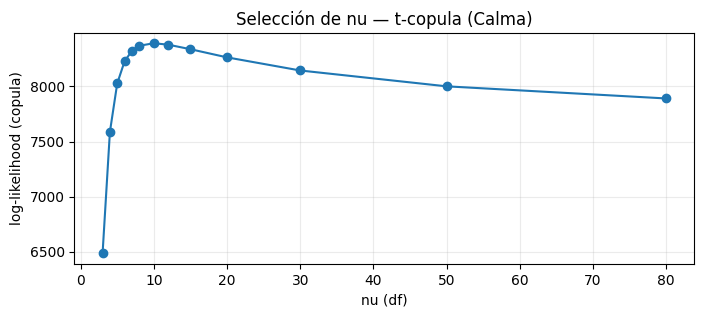

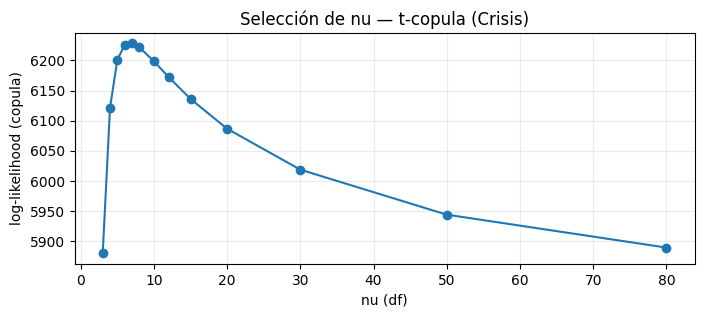

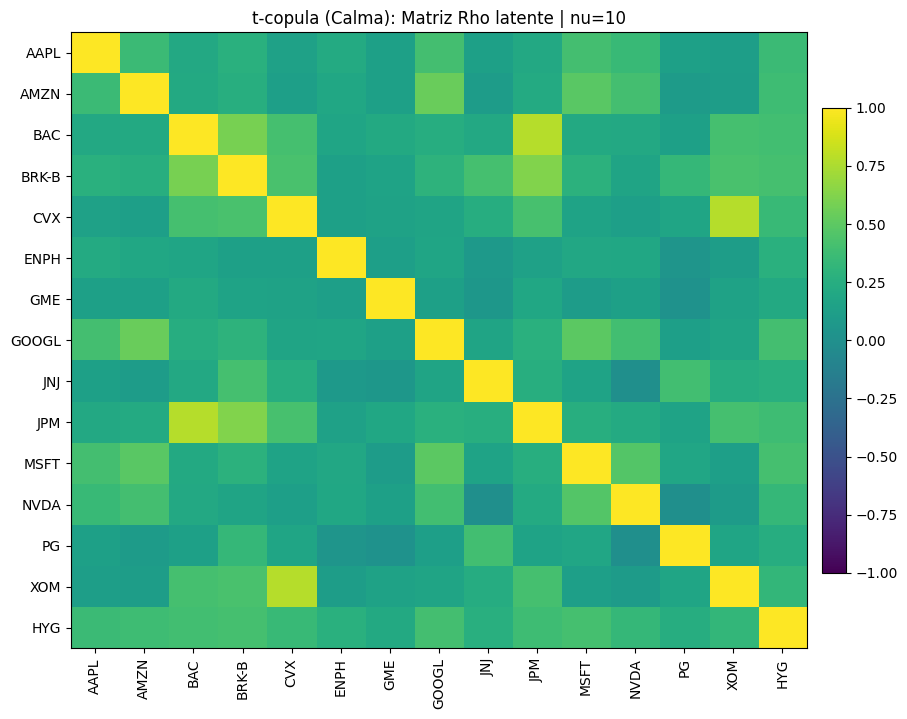

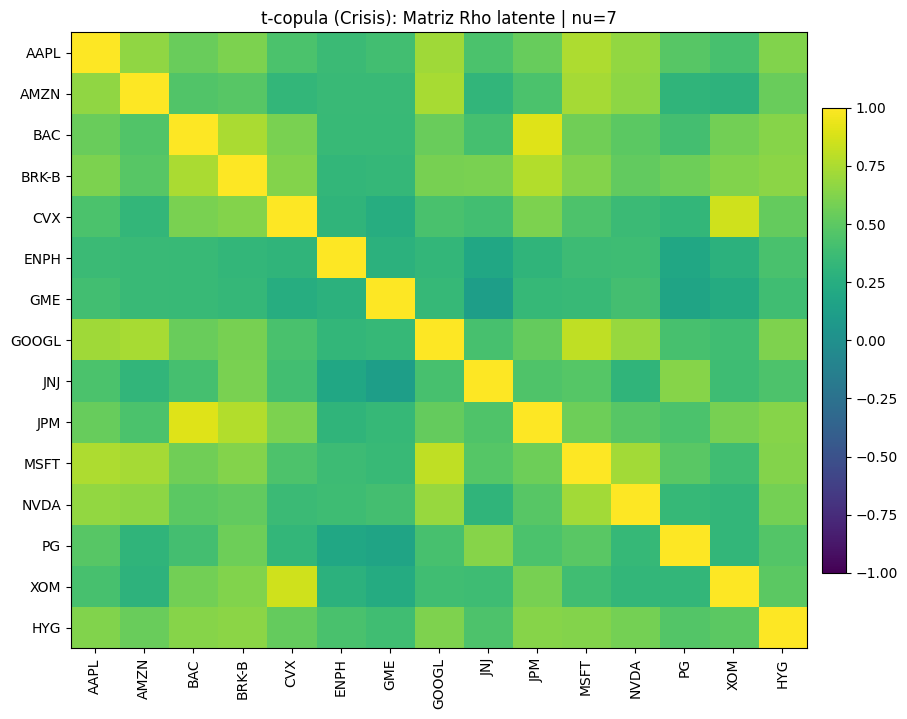

,asset_i,asset_j,rho_latent,lambda_tail
33,BAC,JPM,0.778,0.266
58,CVX,XOM,0.775,0.262
44,BRK-B,JPM,0.625,0.139
27,BAC,BRK-B,0.592,0.121
19,AMZN,GOOGL,0.543,0.099
79,GOOGL,MSFT,0.494,0.080
22,AMZN,MSFT,0.485,0.077
95,MSFT,NVDA,0.467,0.071
48,BRK-B,XOM,0.429,0.060
39,BRK-B,CVX,0.426,0.059


,asset_i,asset_j,rho_latent,lambda_tail
33,BAC,JPM,0.899,0.533
58,CVX,XOM,0.858,0.457
79,GOOGL,MSFT,0.808,0.384
44,BRK-B,JPM,0.773,0.341
9,AAPL,MSFT,0.758,0.324
27,BAC,BRK-B,0.748,0.314
19,AMZN,GOOGL,0.737,0.303
22,AMZN,MSFT,0.729,0.296
95,MSFT,NVDA,0.725,0.292
6,AAPL,GOOGL,0.714,0.281



Resumen tail dependence (t-copula):
Media λ (Calma):  0.03508416562636476
Media λ (Crisis): 0.14948204410323837


,asset_i,asset_j,kendall_tau,theta_clayton,lambda_L
58,CVX,XOM,0.605,3.066,0.798
33,BAC,JPM,0.600,2.994,0.793
44,BRK-B,JPM,0.433,1.530,0.636
27,BAC,BRK-B,0.402,1.345,0.597
19,AMZN,GOOGL,0.387,1.263,0.578
79,GOOGL,MSFT,0.359,1.120,0.539
22,AMZN,MSFT,0.343,1.046,0.515
95,MSFT,NVDA,0.310,0.898,0.462
6,AAPL,GOOGL,0.300,0.856,0.445
87,JNJ,PG,0.300,0.855,0.445


,asset_i,asset_j,kendall_tau,theta_clayton,lambda_L
58,CVX,XOM,0.709,4.869,0.867
33,BAC,JPM,0.702,4.703,0.863
19,AMZN,GOOGL,0.532,2.274,0.737
79,GOOGL,MSFT,0.529,2.245,0.734
6,AAPL,GOOGL,0.509,2.070,0.715
9,AAPL,MSFT,0.496,1.971,0.703
22,AMZN,MSFT,0.491,1.927,0.698
44,BRK-B,JPM,0.475,1.812,0.682
95,MSFT,NVDA,0.466,1.747,0.673
0,AAPL,AMZN,0.466,1.745,0.672


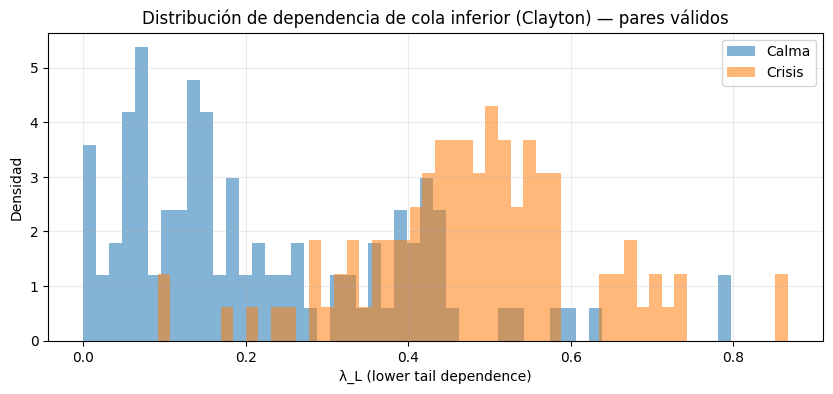


Resumen λ_L (Clayton):
Media λ_L Calma:  0.2227510164744704
Media λ_L Crisis: 0.4796511707013288


In [14]:
# ============================================================
# FASE 3 — Cuando la Diversificación Falla (Cópulas)
#   - Pearson Corr: Calma vs Estrés
#   - t-Copula multivariante: ν alto en calma / ν bajo en estrés (estimado)
#   - Extra: Clayton (bivariada) para cola izquierda (riesgo de caídas conjuntas)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from IPython.display import display, Markdown

# -----------------------------
# 0) Checks + preparar retornos y estados
# -----------------------------
if "px" not in globals():
    raise ValueError("No encuentro `px`. Ejecuta la parte de descarga y limpieza de datos.")
if "states" not in globals() or "crisis_state" not in globals():
    raise ValueError("No encuentro `states` y/o `crisis_state`. Ejecuta primero la Fase 1 (HMM).")

# Estado 0/1: 0=Calma, 1=Crisis
S01 = (states == int(crisis_state)).astype(int)
S01.name = "state01"

# Universo (mismo que usas en Fase 2, pero robusto a columnas faltantes)
universe = [
    "AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GLD","GME","GOOGL","JNJ",
    "JPM","MSFT","NVDA","PG","XOM","IEF","SHY","HYG","SPY"
]
universe = [t for t in universe if t in px.columns]

# Retornos log (sin dropna global)
R = np.log(px[universe]).diff()

# Alinear índices con estados (solo días donde HMM tiene estado)
common_idx = R.index.intersection(S01.index)
R = R.loc[common_idx]
S01 = S01.loc[common_idx]

# Subconjuntos útiles para interpretación económica
equities = [t for t in ["AAPL","AMZN","BAC","BRK-B","CVX","ENPH","GME","GOOGL","JNJ","JPM","MSFT","NVDA","PG","XOM"] if t in R.columns]
risk_assets = [t for t in (equities + (["HYG"] if "HYG" in R.columns else [])) if t in R.columns]
def_assets  = [t for t in ["IEF","SHY","GLD"] if t in R.columns]

print("Activos totales:", len(universe), "| Risk assets:", len(risk_assets), "| Defensivos:", len(def_assets))
print("Obs. totales alineadas:", len(R), "| % Crisis:", 100*S01.mean(), "%")

# -----------------------------
# Helpers
# -----------------------------
def offdiag_mean(C: pd.DataFrame) -> float:
    A = C.values
    mask = ~np.eye(A.shape[0], dtype=bool)
    return np.nanmean(A[mask])

def plot_heatmap_corr(C: pd.DataFrame, title: str, vmin=-1, vmax=1):
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(C.values, aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(C.shape[1]))
    ax.set_yticks(range(C.shape[0]))
    ax.set_xticklabels(C.columns, rotation=90)
    ax.set_yticklabels(C.index)
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    ax.grid(False)
    plt.show()

def pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """Pseudo-observaciones U(0,1) via ranks: u = rank/(n+1)."""
    X = df.values
    n, k = X.shape
    U = np.empty_like(X, dtype=float)
    for j in range(k):
        col = X[:, j]
        # rankdata maneja empates
        r = st.rankdata(col, method="average")
        U[:, j] = r / (n + 1.0)
    return U

def nearest_psd(A: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    """Proyecta a PSD por clipping de eigenvalores."""
    A = 0.5 * (A + A.T)
    w, V = np.linalg.eigh(A)
    w = np.maximum(w, eps)
    B = (V * w) @ V.T
    # normalizar a correlación (diag = 1)
    d = np.sqrt(np.diag(B))
    B = B / np.outer(d, d)
    return 0.5 * (B + B.T)

def fit_t_copula_ifm(df: pd.DataFrame, nu_grid=None, shrink=0.02):
    """
    Ajuste IFM semiparamétrico:
      - U por ranks
      - Para cada nu candidato:
          Z = t^{-1}(U; nu)
          Rho = corr(Z)
          (shrink + nearest PSD)
          loglik = sum log c(u)
    Devuelve: nu_hat, Rho_hat, ll_df (tabla)
    """
    if nu_grid is None:
        nu_grid = [3,4,5,6,7,8,10,12,15,20,30,50,80]

    X = df.dropna(axis=0, how="any")
    if len(X) < 200:
        raise ValueError(f"Pocas observaciones completas para copula: {len(X)} (<200). Reduce activos o baja filtros.")

    U = pseudo_obs(X)
    k = U.shape[1]
    ll_list = []

    for nu in nu_grid:
        # Transformación t
        Z = st.t.ppf(U, df=nu)
        # Correlación en el espacio latente
        Rho = np.corrcoef(Z, rowvar=False)
        # Shrinkage leve para estabilidad
        Rho = (1 - shrink) * Rho + shrink * np.eye(k)
        Rho = nearest_psd(Rho)

        # log c(u) = log f_tk(Z;nu,Rho) - sum log f_t1(Z_i;nu)
        mvt = st.multivariate_t(loc=np.zeros(k), shape=Rho, df=nu)
        ll_m = mvt.logpdf(Z).sum()
        ll_u = st.t.logpdf(Z, df=nu).sum()
        ll = ll_m - ll_u
        ll_list.append((nu, ll, len(X), k))

    ll_df = pd.DataFrame(ll_list, columns=["nu", "loglik", "N", "K"]).sort_values("loglik", ascending=False)
    nu_hat = int(ll_df.iloc[0]["nu"])

    # Re-estimar Rho con nu_hat
    Z = st.t.ppf(U, df=nu_hat)
    Rho = np.corrcoef(Z, rowvar=False)
    Rho = (1 - shrink) * Rho + shrink * np.eye(k)
    Rho = nearest_psd(Rho)

    return nu_hat, Rho, ll_df, X.columns

def t_tail_dependence(rho: float, nu: float) -> float:
    """
    Coeficiente de dependencia en cola (simétrica) para t-copula:
    λ = 2 * t_{nu+1}(-sqrt((nu+1)*(1-rho)/(1+rho)))
    """
    if rho >= 0.999999:
        return 1.0
    if rho <= -0.999999:
        return 0.0
    a = -np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return 2.0 * st.t.cdf(a, df=nu + 1.0)

def clayton_theta_from_tau(tau: float) -> float:
    """Clayton: theta = 2*tau/(1-tau) para tau in (0,1)."""
    if tau <= 0 or tau >= 0.999999:
        return np.nan
    return 2.0 * tau / (1.0 - tau)

def clayton_lower_tail(theta: float) -> float:
    """Clayton: lambda_L = 2^(-1/theta)."""
    if not np.isfinite(theta) or theta <= 0:
        return np.nan
    return 2.0 ** (-1.0 / theta)

# -----------------------------
# 1) Correlación Pearson por régimen
# -----------------------------
R_calm = R.loc[S01==0]
R_cris = R.loc[S01==1]

# Filtro de columnas con datos suficientes en ambos regímenes (para comparabilidad)
MIN_N = 400
good = []
for c in R.columns:
    n0 = R_calm[c].count()
    n1 = R_cris[c].count()
    if (n0 >= MIN_N) and (n1 >= MIN_N):
        good.append(c)

R0 = R_calm[good]
R1 = R_cris[good]

C0 = R0.corr(method="pearson")
C1 = R1.corr(method="pearson")

print("\n--- Pearson (activos con N>=MIN_N en ambos regímenes) ---")
print("K =", len(good), "| N_calm(min col count) =", int(R0.count().min()), "| N_crisis(min col count) =", int(R1.count().min()))
print("Corr media off-diag (Calma):  ", offdiag_mean(C0))
print("Corr media off-diag (Crisis): ", offdiag_mean(C1))

# Heatmaps
plot_heatmap_corr(C0, "Matriz de correlación Pearson — Calma", vmin=-1, vmax=1)
plot_heatmap_corr(C1, "Matriz de correlación Pearson — Estrés/Crisis", vmin=-1, vmax=1)

# Distribución de correlaciones (off-diagonal)
def vec_offdiag(C):
    A = C.values
    mask = ~np.eye(A.shape[0], dtype=bool)
    return A[mask]

v0 = vec_offdiag(C0)
v1 = vec_offdiag(C1)

fig, ax = plt.subplots(figsize=(10,4))
ax.hist(v0, bins=60, density=True, alpha=0.55, label="Calma")
ax.hist(v1, bins=60, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de correlaciones (off-diagonal)")
ax.set_xlabel("Correlación")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

# Métricas “risk assets” (suele ser donde se ve el “correlation goes to 1”)
risk_good = [t for t in risk_assets if t in good]
if len(risk_good) >= 3:
    C0_r = R0[risk_good].corr()
    C1_r = R1[risk_good].corr()
    print("\n--- Solo Risk Assets (equities + HYG) ---")
    print("K_risk =", len(risk_good))
    print("Corr media off-diag (Calma):  ", offdiag_mean(C0_r))
    print("Corr media off-diag (Crisis): ", offdiag_mean(C1_r))

# -----------------------------
# 2) Ajuste t-cópula multivariante por régimen (IFM)
# -----------------------------
# Para copula conviene usar un set coherente y con datos completos:
# usamos los mismos "good" y además eliminamos defensivos si quieres enfocarte en riesgo sistémico.
# (Puedes comentar la siguiente línea si prefieres incluir TODO)
focus_assets = good.copy()

# Opción: foco solo en risk assets si hay suficientes
if len(risk_good) >= 6:
    focus_assets = risk_good

print("\n--- Ajuste t-cópula (multivariante) ---")
print("Activos usados para copula:", focus_assets)

X0 = R0[focus_assets].dropna(how="any")
X1 = R1[focus_assets].dropna(how="any")

print("N completo Calma:", len(X0), "| N completo Crisis:", len(X1), "| K:", len(focus_assets))

nu_grid = [3,4,5,6,7,8,10,12,15,20,30,50,80]

nu0, Rho0, ll0, cols0 = fit_t_copula_ifm(X0, nu_grid=nu_grid, shrink=0.02)
nu1, Rho1, ll1, cols1 = fit_t_copula_ifm(X1, nu_grid=nu_grid, shrink=0.02)

print(f"\n[RESULT] t-copula Calma:  nu_hat = {nu0}")
print(f"[RESULT] t-copula Crisis: nu_hat = {nu1}")

# Tabla log-likelihood (top 8)
display(ll0.head(8).style.format({"loglik":"{:.1f}"}).set_caption("t-copula — Calma (mejores nu por log-likelihood)"))
display(ll1.head(8).style.format({"loglik":"{:.1f}"}).set_caption("t-copula — Crisis (mejores nu por log-likelihood)"))

# Plot ll vs nu
def plot_ll(ll_df, title):
    tmp = ll_df.sort_values("nu")
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(tmp["nu"], tmp["loglik"], marker="o")
    ax.set_title(title)
    ax.set_xlabel("nu (df)")
    ax.set_ylabel("log-likelihood (copula)")
    ax.grid(True, alpha=0.25)
    plt.show()

plot_ll(ll0, "Selección de nu — t-copula (Calma)")
plot_ll(ll1, "Selección de nu — t-copula (Crisis)")

# Mostrar matrices de correlación latente (copula) como heatmap
C_t0 = pd.DataFrame(Rho0, index=cols0, columns=cols0)
C_t1 = pd.DataFrame(Rho1, index=cols1, columns=cols1)

plot_heatmap_corr(C_t0, f"t-copula (Calma): Matriz Rho latente | nu={nu0}", vmin=-1, vmax=1)
plot_heatmap_corr(C_t1, f"t-copula (Crisis): Matriz Rho latente | nu={nu1}", vmin=-1, vmax=1)

# Tail dependence (t-copula) por pares: resumen
def pair_table_taildep(Rho, cols, nu, top=12):
    cols = list(cols)
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            rho = float(Rho[i, j])
            lam = t_tail_dependence(rho, nu)
            out.append((cols[i], cols[j], rho, lam))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","rho_latent","lambda_tail"])
    df = df.sort_values("lambda_tail", ascending=False)
    return df.head(top), df

top0, all0 = pair_table_taildep(Rho0, cols0, nu0, top=12)
top1, all1 = pair_table_taildep(Rho1, cols1, nu1, top=12)

display(top0.style.format({"rho_latent":"{:.3f}","lambda_tail":"{:.3f}"}).set_caption("t-copula — Top tail dependence (Calma)"))
display(top1.style.format({"rho_latent":"{:.3f}","lambda_tail":"{:.3f}"}).set_caption("t-copula — Top tail dependence (Crisis)"))

print("\nResumen tail dependence (t-copula):")
print("Media λ (Calma): ", all0["lambda_tail"].mean())
print("Media λ (Crisis):", all1["lambda_tail"].mean())

# -----------------------------
# 3) EXTRA — Clayton bivariada (cola inferior) por régimen
# -----------------------------
# Clayton es especialmente útil para “caídas conjuntas” (lower tail dependence).
# Lo hacemos bivariado por pares y comparamos Calma vs Crisis.
pairs_assets = focus_assets  # mismo conjunto que usaste arriba
X0p = R0[pairs_assets]
X1p = R1[pairs_assets]

# Kendall tau por régimen
Tau0 = X0p.corr(method="kendall")
Tau1 = X1p.corr(method="kendall")

def clayton_table(Tau_mat: pd.DataFrame, top=15, title=""):
    cols = Tau_mat.columns
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau_mat.iloc[i, j]
            theta = clayton_theta_from_tau(tau)
            lamL  = clayton_lower_tail(theta)
            out.append((cols[i], cols[j], float(tau), float(theta) if np.isfinite(theta) else np.nan, float(lamL) if np.isfinite(lamL) else np.nan))
    df = pd.DataFrame(out, columns=["asset_i","asset_j","kendall_tau","theta_clayton","lambda_L"])
    df = df.dropna(subset=["lambda_L"]).sort_values("lambda_L", ascending=False).head(top)
    return df

cl0 = clayton_table(Tau0, top=15)
cl1 = clayton_table(Tau1, top=15)

display(cl0.style.format({"kendall_tau":"{:.3f}","theta_clayton":"{:.3f}","lambda_L":"{:.3f}"}).set_caption("Clayton (Calma) — Top cola inferior"))
display(cl1.style.format({"kendall_tau":"{:.3f}","theta_clayton":"{:.3f}","lambda_L":"{:.3f}"}).set_caption("Clayton (Crisis) — Top cola inferior"))

# Comparativa simple: distribución de λ_L (Clayton) en calma vs crisis (para todos los pares válidos)
def all_lambdaL(Tau_mat):
    cols = Tau_mat.columns
    vals = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau_mat.iloc[i, j]
            th = clayton_theta_from_tau(tau)
            lamL = clayton_lower_tail(th)
            if np.isfinite(lamL):
                vals.append(lamL)
    return np.array(vals)

lam0 = all_lambdaL(Tau0)
lam1 = all_lambdaL(Tau1)

fig, ax = plt.subplots(figsize=(10,4))
ax.hist(lam0, bins=50, density=True, alpha=0.55, label="Calma")
ax.hist(lam1, bins=50, density=True, alpha=0.55, label="Crisis")
ax.set_title("Distribución de dependencia de cola inferior (Clayton) — pares válidos")
ax.set_xlabel("λ_L (lower tail dependence)")
ax.set_ylabel("Densidad")
ax.grid(True, alpha=0.25)
ax.legend()
plt.show()

print("\nResumen λ_L (Clayton):")
print("Media λ_L Calma: ", np.nanmean(lam0) if len(lam0)>0 else np.nan)
print("Media λ_L Crisis:", np.nanmean(lam1) if len(lam1)>0 else np.nan)

Media empirical λ_L (Calma): 0.19504362254455923
Media empirical λ_L (Crisis): 0.3239706030403705
Media Clayton λ_L (Calma):    0.2227510164744704
Media Clayton λ_L (Crisis):   0.4796511707013288
Media t λ (Calma):            0.03508416562636476
Media t λ (Crisis):           0.14948204410323837

Spearman(emp vs Clayton) Calma: 0.892
Spearman(emp vs Clayton) Crisis:0.862


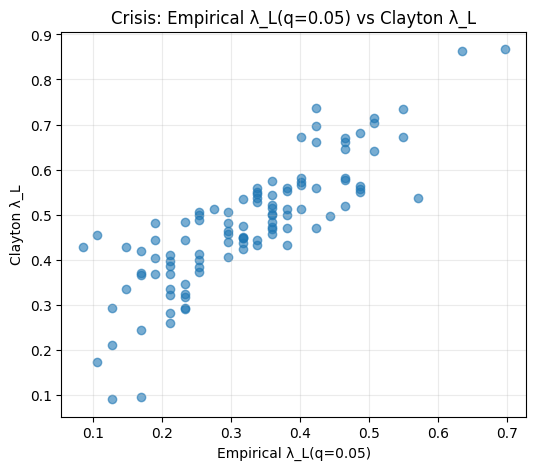

,asset_i,asset_j,emp_lambdaL_q0.05,clayton_lambdaL,t_lambda
58,CVX,XOM,0.697674,0.867319,0.457171
33,BAC,JPM,0.634249,0.862966,0.532684
45,BRK-B,MSFT,0.570825,0.537243,0.212351
79,GOOGL,MSFT,0.549683,0.734412,0.383749
95,MSFT,NVDA,0.549683,0.672512,0.291913
9,AAPL,MSFT,0.507400,0.703495,0.324234
23,AMZN,NVDA,0.507400,0.640750,0.233909
6,AAPL,GOOGL,0.507400,0.715475,0.281056
37,BAC,XOM,0.486258,0.549390,0.179592
42,BRK-B,GOOGL,0.486258,0.556208,0.189841


In [15]:

# Asumo que ya tienes:
# R0 = retornos en calma (dataframe con focus_assets)
# R1 = retornos en crisis
# focus_assets, nu0, nu1, Rho0, Rho1, cols0, cols1
# Tau0, Tau1 (kendall matrices) si usaste clayton

def empirical_lambda_L(df, q=0.05):
    """Empirical lower-tail dependence per pair using threshold q."""
    X = df.dropna(how="any")
    U = np.zeros_like(X.values, dtype=float)
    # ranks -> uniform
    for j in range(X.shape[1]):
        r = st.rankdata(X.iloc[:, j].values, method="average")
        U[:, j] = r / (len(X) + 1.0)
    cols = list(X.columns)
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            ui, uj = U[:, i], U[:, j]
            p_joint = np.mean((ui <= q) & (uj <= q))
            lam_hat = p_joint / q if q > 0 else np.nan
            out.append((cols[i], cols[j], lam_hat))
    return pd.DataFrame(out, columns=["asset_i","asset_j",f"emp_lambdaL_q{q}"])

def clayton_lambdaL_from_tau(Tau):
    cols = Tau.columns
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            tau = Tau.iloc[i, j]
            if tau <= 0 or tau >= 0.999999:
                continue
            theta = 2*tau/(1-tau)
            lamL = 2**(-1/theta)
            out.append((cols[i], cols[j], lamL))
    return pd.DataFrame(out, columns=["asset_i","asset_j","clayton_lambdaL"])

def t_lambda_from_rho(Rho, cols, nu):
    out = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            rho = float(Rho[i,j])
            if rho >= 0.999999:
                lam = 1.0
            else:
                a = -np.sqrt((nu+1)*(1-rho)/(1+rho))
                lam = 2*st.t.cdf(a, df=nu+1)
            out.append((cols[i], cols[j], lam))
    return pd.DataFrame(out, columns=["asset_i","asset_j","t_lambda"])

# ---- elige un q para validar cola (5% es estándar)
q = 0.05

emp0 = empirical_lambda_L(R0[focus_assets], q=q)
emp1 = empirical_lambda_L(R1[focus_assets], q=q)

cl0 = clayton_lambdaL_from_tau(Tau0.loc[focus_assets, focus_assets])
cl1 = clayton_lambdaL_from_tau(Tau1.loc[focus_assets, focus_assets])

t0 = t_lambda_from_rho(Rho0, list(cols0), nu0)
t1 = t_lambda_from_rho(Rho1, list(cols1), nu1)

# merge
m0 = emp0.merge(cl0, on=["asset_i","asset_j"], how="left").merge(t0, on=["asset_i","asset_j"], how="left")
m1 = emp1.merge(cl1, on=["asset_i","asset_j"], how="left").merge(t1, on=["asset_i","asset_j"], how="left")

print("Media empirical λ_L (Calma):", m0[f"emp_lambdaL_q{q}"].mean())
print("Media empirical λ_L (Crisis):", m1[f"emp_lambdaL_q{q}"].mean())
print("Media Clayton λ_L (Calma):   ", m0["clayton_lambdaL"].mean())
print("Media Clayton λ_L (Crisis):  ", m1["clayton_lambdaL"].mean())
print("Media t λ (Calma):           ", m0["t_lambda"].mean())
print("Media t λ (Crisis):          ", m1["t_lambda"].mean())

# Correlación de rankings (Spearman): empírico vs modelos
rho_sp0 = st.spearmanr(m0[f"emp_lambdaL_q{q}"], m0["clayton_lambdaL"], nan_policy="omit").statistic
rho_sp1 = st.spearmanr(m1[f"emp_lambdaL_q{q}"], m1["clayton_lambdaL"], nan_policy="omit").statistic
print(f"\nSpearman(emp vs Clayton) Calma: {rho_sp0:.3f}")
print(f"Spearman(emp vs Clayton) Crisis:{rho_sp1:.3f}")

# Scatter para ver si hay “inflación rara”
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(m1[f"emp_lambdaL_q{q}"], m1["clayton_lambdaL"], alpha=0.6)
ax.set_title(f"Crisis: Empirical λ_L(q={q}) vs Clayton λ_L")
ax.set_xlabel(f"Empirical λ_L(q={q})")
ax.set_ylabel("Clayton λ_L")
ax.grid(True, alpha=0.25)
plt.show()

# Top 10 pares por empírico en crisis (para ver si el modelo los “respeta”)
display(
    m1.sort_values(by=f"emp_lambdaL_q{q}", ascending=False)
      .head(10)[["asset_i","asset_j",f"emp_lambdaL_q{q}","clayton_lambdaL","t_lambda"]]
)
